# Denoising Model Training

## Basic information in this notebook

In [22]:
%load_ext autoreload
%autoreload 2

!python --version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python 3.13.11


In [23]:
import torch

if torch.cuda.is_available():
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"CUDA is available. Number of GPUs: {gpu_count}")
    
    # Iterate over all available GPUs to print details
    for i in range(gpu_count):
        print(f"\n--- GPU Device {i} ---")
        # Get the name of the GPU
        print(f"Device Name: {torch.cuda.get_device_name(i)}")
        
        # Get general properties
        properties = torch.cuda.get_device_properties(i)
        print(f"Total Memory: {round(properties.total_memory / (1024**3), 2)} GB")
        print(f"Multiprocessor Count: {properties.multi_processor_count}")
        print(f"CUDA Capability: {properties.major}.{properties.minor}")

else:
    print("CUDA is not available. PyTorch is using CPU.")

# for MAC GPU
print("\nChecking for MPS (Apple Silicon GPU) support...")
if torch.backends.mps.is_available():
    print("MPS (GPU) is available.")
else:
    print("MPS not available.")

CUDA is available. Number of GPUs: 1

--- GPU Device 0 ---
Device Name: NVIDIA GeForce RTX 4090
Total Memory: 23.52 GB
Multiprocessor Count: 128
CUDA Capability: 8.9

Checking for MPS (Apple Silicon GPU) support...
MPS not available.


## Data Load and presentation

In [24]:
import gc
gc.collect()

import torch
torch.cuda.empty_cache()

In [25]:
""" Default or Suggested Settings """
PATCH_SIZE_2D = (64, 64)
PATCH_SIZE_3D = (32, 64, 64)
SLIDE_WINDOW_2D = (16, 16)
SLIDE_WINDOW_3D = (8, 16, 16)
NMODE_ENABLE = False
SEED = 42
MASK_MODE = "gaussian"  # "gaussian", "global_surrounding", "local_surrounding"

""" overwrite settings below """

""" Set PATCH_SIZE to either 2D or 3D based on your requirements"""
# PATCH_SIZE = PATCH_SIZE_2D
PATCH_SIZE = PATCH_SIZE_3D

# SLIDE_WINDOW = SLIDE_WINDOW_2D
SLIDE_WINDOW = SLIDE_WINDOW_3D

# MASK_MODE = "local_surrounding"

# NMODE_ENABLE = True

In [26]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    """
    DataLoader 的 worker 初始化函數
    確保每個 worker 擁有獨立但固定的 NumPy/Python seed
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed_everything(SEED)

In [27]:
import pathlib
import sys, os
import tifffile
from torch.utils.data import DataLoader
from dataset import CalciumDataset

if "google.colab" in sys.modules:
    train_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/train")
    valid_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid")
    ground_truth_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid/F0.tif")
else:
    train_path = pathlib.Path("data/train")
    valid_path = pathlib.Path("data/valid")
    ground_truth_path = pathlib.Path("data/valid/F0.tif")

train_paths = list(train_path.glob("*.tif"))
valid_paths = [p for p in valid_path.glob("*.tif") if "f0" not in p.name.lower()]
valid_paths.sort()
ground_truth = tifffile.imread(ground_truth_path)

print(len(train_paths), len(valid_paths))
print(train_paths)
print(valid_paths)

if PATCH_SIZE == PATCH_SIZE_2D:
    train_dataset = CalciumDataset(train_paths, subset="train", patch_size=PATCH_SIZE, samples_per_epoch=8000, mask_mode=MASK_MODE)
    valid_dataset = CalciumDataset(valid_paths, subset="valid", patch_size=PATCH_SIZE, samples_per_epoch=2000, mask_mode=MASK_MODE)
elif PATCH_SIZE == PATCH_SIZE_3D:
    train_dataset = CalciumDataset(train_paths, subset="train", patch_size=PATCH_SIZE, samples_per_epoch=8000, mask_mode=MASK_MODE)
    valid_dataset = CalciumDataset(valid_paths, subset="valid", patch_size=PATCH_SIZE, samples_per_epoch=2000, mask_mode=MASK_MODE)
else:
    raise ValueError("Invalid PATCH_SIZE. Must be either PATCH_SIZE_2D or PATCH_SIZE_3D.")


4 3
[PosixPath('data/train/A1.tif'), PosixPath('data/train/B1.tif'), PosixPath('data/train/C2.tif'), PosixPath('data/train/D2.tif')]
[PosixPath('data/valid/F1.tif'), PosixPath('data/valid/F2.tif'), PosixPath('data/valid/F3.tif')]


KeyboardInterrupt: 

In [ ]:
for normals in train_dataset.normals:
    print(normals)
for normals in valid_dataset.normals:
    print(normals)

(np.float64(-89.0), np.float64(1275.0))
(np.float64(-89.0), np.float64(1275.0))
(np.float64(-89.0), np.float64(1275.0))
(np.float64(-89.0), np.float64(1275.0))
(np.float64(-100.0), np.float64(2090.0))
(np.float64(-100.0), np.float64(2090.0))
(np.float64(-100.0), np.float64(2090.0))


## Check Augmentation

=== 正在進行 Augmentation 邏輯測試 (Synthetic) ===


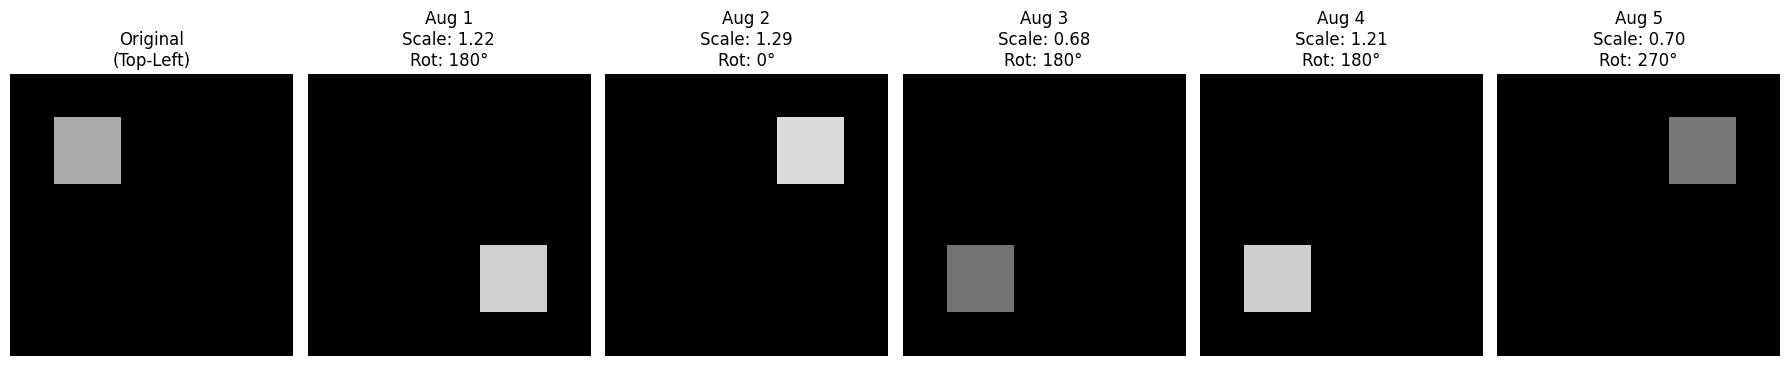

檢查重點：
1. 亮塊是否跑到不同角落？(旋轉)
2. 亮度是否忽明忽暗？(亮度增強)
3. 形狀是否維持方形？(沒有被拉伸變形)

=== 正在進行 真實資料驗證 (Real Data) ===


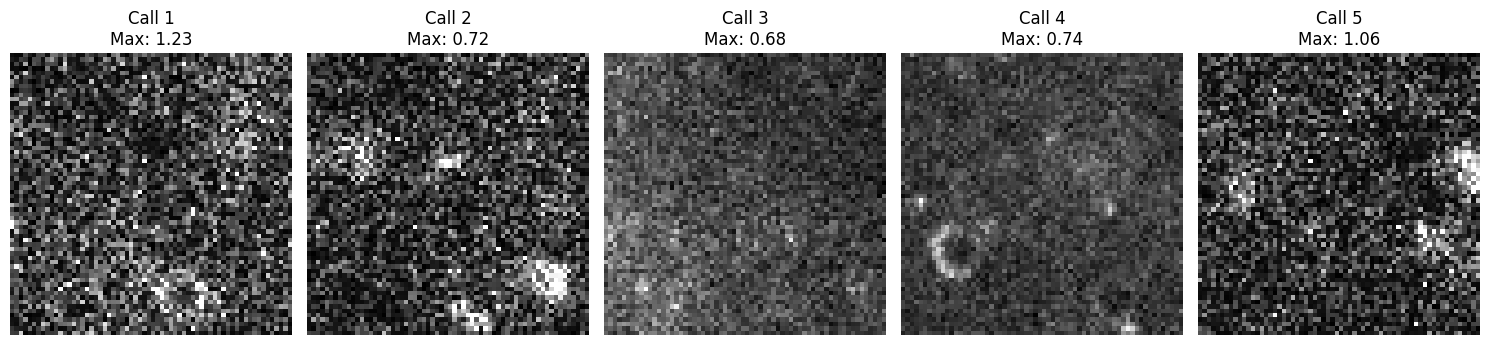

檢查重點：
1. 每次呼叫同一張圖，看到的細胞位置/角度是否不同？
2. 亮度最大值 (Max) 是否有跳動？


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def verify_augmentation_logic():
    """
    用人工合成的圖案來嚴格測試 Augmentation 的邏輯。
    這樣可以看出旋轉、翻轉是否正確，而不會被顯微影像的雜訊干擾。
    """
    print("=== 正在進行 Augmentation 邏輯測試 (Synthetic) ===")
    
    # 1. 建立一個不對稱的 3D Patch (C, D, H, W)
    # 假設: 1 Channel, 5 Frames, 64x64
    # 我們在 "左上角" 畫一個亮塊，這樣旋轉後它應該會跑到不同角落
    patch = torch.zeros((1, 5, 64, 64))
    patch[:, :, 10:25, 10:25] = 0.5  # 基礎亮度 0.5 (灰色)
    
    # 為了測試這是不是真的 3D 結構，我們在第 0 frame 加一點特別的東西
    patch[:, 0, 10:25, 10:25] = 1.0  # 第 0 frame 特別亮 (白色)

    # 模擬你的 apply_augmentation 函數 (請確保這跟你的 Class 裡的一樣)
    def apply_augmentation_mock(patch, rng):
        # --- 複製你的邏輯 ---
        # 1. Brightness
        min_scale, max_scale = 0.6, 1.4
        scale_factor = rng.uniform(min_scale, max_scale)
        patch_aug = patch * scale_factor
        
        # 2. Geometric
        # Rotate
        rot_k = rng.integers(0, 4)
        patch_aug = torch.rot90(patch_aug, rot_k, dims=(-2, -1))
        
        # Flip
        if rng.integers(0, 2) == 1:
            patch_aug = torch.flip(patch_aug, dims=(-1,))
            
        return patch_aug, scale_factor, rot_k

    # 2. 產生 5 種不同的 Augmentation 結果
    rng = np.random.default_rng(42) # 固定種子方便觀察
    
    fig, axes = plt.subplots(1, 6, figsize=(18, 4))
    
    # 顯示原圖 (第 0 frame)
    axes[0].imshow(patch[0, 0], cmap='gray', vmin=0, vmax=1.5)
    axes[0].set_title("Original\n(Top-Left)")
    axes[0].axis('off')

    for i in range(1, 6):
        aug_patch, scale, rot = train_dataset.apply_augmentation(patch.clone(), rng, mock=True)
        
        # 顯示 Augmentation 後的第 0 frame
        axes[i].imshow(aug_patch[0, 0], cmap='gray', vmin=0, vmax=1.5)
        
        # 標題顯示做了什麼
        rot_deg = rot * 90
        axes[i].set_title(f"Aug {i}\nScale: {scale:.2f}\nRot: {rot_deg}°")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    print("檢查重點：\n1. 亮塊是否跑到不同角落？(旋轉)\n2. 亮度是否忽明忽暗？(亮度增強)\n3. 形狀是否維持方形？(沒有被拉伸變形)")

def verify_real_dataset(dataset):
    """
    檢查實際 Dataset 輸出的圖片
    dataset: 你的 CalciumDataset 實例 (mode='train')
    """
    print("\n=== 正在進行 真實資料驗證 (Real Data) ===")
    
    rng = np.random.default_rng()
    idx = 0 # 測試第 0 張圖
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    
    for i in range(5):
        # 因為你的 Dataset 是 on-the-fly random，每次呼叫 __getitem__ 結果都應該不同
        masked_img, mask, target = dataset[idx]
        
        # 這裡我們看 target (因為它是完整的圖，比較好看出 augment)
        # 取中間的 Frame (depth // 2) 來畫
        mid_frame = target.shape[1] // 2
        img_show = target[0, mid_frame].cpu().numpy()
        
        axes[i].imshow(img_show, cmap='gray')
        axes[i].set_title(f"Call {i+1}\nMax: {img_show.max():.2f}")
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    print("檢查重點：\n1. 每次呼叫同一張圖，看到的細胞位置/角度是否不同？\n2. 亮度最大值 (Max) 是否有跳動？")

# ==========================================
# 執行區 (請解開註解使用)
# ==========================================

# 1. 先跑邏輯驗證
verify_augmentation_logic()

# 2. 如果你有 dataset 物件，可以跑這個
verify_real_dataset(train_dataset)

In [ ]:
seed_everything(SEED)
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g)

## Model Training

In [ ]:
from model_arch.unet import UNet, UNet3D, UNetnmODE
from training import train

best_model = None
if PATCH_SIZE == PATCH_SIZE_3D:
    if NMODE_ENABLE:
        model = UNetnmODE()
        print("Using UNet with nmODE")
    else:
        model = UNet3D()
        print("Using 3D UNet")
elif PATCH_SIZE == PATCH_SIZE_2D:
    model = UNet()
    print("Using 2D UNet")
else:
    raise ValueError("Invalid PATCH_SIZE. Must be either PATCH_SIZE_2D or PATCH_SIZE_3D.")
    
best_model = train(model, train_loader, valid_loader, epochs=20)

Using UNet with nmODE


Epoch 1/100


100%|██████████| 63/63 [00:06<00:00,  9.45it/s, loss=0.0157]


Epoch: 1, Valid Loss: 0.018273415812660777
Best model saved with loss: 0.018273415812660777
Epoch 2/100


100%|██████████| 63/63 [00:06<00:00,  9.73it/s, loss=0.0155]


Epoch: 2, Valid Loss: 0.01816807532062133
Best model saved with loss: 0.01816807532062133
Epoch 3/100


100%|██████████| 63/63 [00:06<00:00,  9.36it/s, loss=0.0155]


Epoch: 3, Valid Loss: 0.018124231477341955
Best model saved with loss: 0.018124231477341955
Epoch 4/100


100%|██████████| 63/63 [00:06<00:00,  9.06it/s, loss=0.0155]


Epoch: 4, Valid Loss: 0.018100472773233102
Best model saved with loss: 0.018100472773233102
Epoch 5/100


100%|██████████| 63/63 [00:06<00:00,  9.16it/s, loss=0.0155]


Epoch: 5, Valid Loss: 0.018088086138642025
Best model saved with loss: 0.018088086138642025
Epoch 6/100


100%|██████████| 63/63 [00:06<00:00,  9.32it/s, loss=0.0155]


Epoch: 6, Valid Loss: 0.018081262471183898
Best model saved with loss: 0.018081262471183898
Epoch 7/100


100%|██████████| 63/63 [00:06<00:00,  9.56it/s, loss=0.0155]


Epoch: 7, Valid Loss: 0.01807682179210205
Best model saved with loss: 0.01807682179210205
Epoch 8/100


100%|██████████| 63/63 [00:06<00:00,  9.66it/s, loss=0.0154]


Epoch: 8, Valid Loss: 0.018054722556992184
Best model saved with loss: 0.018054722556992184
Epoch 9/100


100%|██████████| 63/63 [00:06<00:00,  9.20it/s, loss=0.0154]


Epoch: 9, Valid Loss: 0.018024154628316563
Best model saved with loss: 0.018024154628316563
Epoch 10/100


100%|██████████| 63/63 [00:06<00:00,  9.59it/s, loss=0.0154]


Epoch: 10, Valid Loss: 0.01802260997808642
Best model saved with loss: 0.01802260997808642
Epoch 11/100


100%|██████████| 63/63 [00:06<00:00,  9.50it/s, loss=0.0154]


Epoch: 11, Valid Loss: 0.018014636762913257
Best model saved with loss: 0.018014636762913257
Epoch 12/100


100%|██████████| 63/63 [00:06<00:00,  9.32it/s, loss=0.0154]


Epoch: 12, Valid Loss: 0.0180251043555992
Epoch 13/100


100%|██████████| 63/63 [00:06<00:00,  9.45it/s, loss=0.0154]


Epoch: 13, Valid Loss: 0.018016591475951294
Epoch 14/100


100%|██████████| 63/63 [00:06<00:00,  9.25it/s, loss=0.0154]


Epoch: 14, Valid Loss: 0.01800491272043141
Best model saved with loss: 0.01800491272043141
Epoch 15/100


100%|██████████| 63/63 [00:06<00:00,  9.33it/s, loss=0.0154]


Epoch: 15, Valid Loss: 0.01801911129483155
Epoch 16/100


100%|██████████| 63/63 [00:06<00:00,  9.49it/s, loss=0.0154]


Epoch: 16, Valid Loss: 0.018003817913787707
Best model saved with loss: 0.018003817913787707
Epoch 17/100


100%|██████████| 63/63 [00:06<00:00,  9.51it/s, loss=0.0154]


Epoch: 17, Valid Loss: 0.018001894052657817
Best model saved with loss: 0.018001894052657817
Epoch 18/100


100%|██████████| 63/63 [00:06<00:00,  9.58it/s, loss=0.0155]


Epoch: 18, Valid Loss: 0.018057409230442273
Epoch 19/100


100%|██████████| 63/63 [00:06<00:00,  9.67it/s, loss=0.0154]


Epoch: 19, Valid Loss: 0.018030429672863748
Epoch 20/100


100%|██████████| 63/63 [00:06<00:00,  9.01it/s, loss=0.0154]


Epoch: 20, Valid Loss: 0.0179959987807605
Best model saved with loss: 0.0179959987807605
Epoch 21/100


100%|██████████| 63/63 [00:06<00:00,  9.70it/s, loss=0.0154]


Epoch: 21, Valid Loss: 0.018067077053562988
Epoch 22/100


100%|██████████| 63/63 [00:06<00:00,  9.63it/s, loss=0.0154]


Epoch: 22, Valid Loss: 0.018000019019440053
Epoch 23/100


100%|██████████| 63/63 [00:06<00:00,  9.67it/s, loss=0.0154]


Epoch: 23, Valid Loss: 0.01799436297918123
Best model saved with loss: 0.01799436297918123
Epoch 24/100


100%|██████████| 63/63 [00:06<00:00,  9.75it/s, loss=0.0154]


Epoch: 24, Valid Loss: 0.018021626516230523
Epoch 25/100


100%|██████████| 63/63 [00:06<00:00,  9.55it/s, loss=0.0154]


Epoch: 25, Valid Loss: 0.018024689680527128
Epoch 26/100


100%|██████████| 63/63 [00:06<00:00,  9.19it/s, loss=0.0154]


Epoch: 26, Valid Loss: 0.017998028590920426
Epoch 27/100


100%|██████████| 63/63 [00:06<00:00,  9.15it/s, loss=0.0154]


Epoch: 27, Valid Loss: 0.01799458179563757
Epoch 28/100


100%|██████████| 63/63 [00:06<00:00,  9.25it/s, loss=0.0154]


Epoch: 28, Valid Loss: 0.017999495276146464
Epoch 29/100


100%|██████████| 63/63 [00:06<00:00,  9.06it/s, loss=0.0154]


Epoch: 29, Valid Loss: 0.018017455018938533
Epoch 30/100


100%|██████████| 63/63 [00:06<00:00,  9.10it/s, loss=0.0154]


Epoch: 30, Valid Loss: 0.018001772862459933
Epoch 31/100


100%|██████████| 63/63 [00:07<00:00,  8.91it/s, loss=0.0154]


Epoch: 31, Valid Loss: 0.018024149143861398
Epoch 32/100


100%|██████████| 63/63 [00:06<00:00,  9.59it/s, loss=0.0154]


Epoch: 32, Valid Loss: 0.018000861068093586
Epoch 33/100


100%|██████████| 63/63 [00:06<00:00,  9.78it/s, loss=0.0155]


Epoch: 33, Valid Loss: 0.018050468364168726
Epoch 34/100


100%|██████████| 63/63 [00:06<00:00,  9.63it/s, loss=0.0154]


Epoch: 34, Valid Loss: 0.0180315508965462
Epoch 35/100


100%|██████████| 63/63 [00:06<00:00,  9.49it/s, loss=0.0155]


Epoch: 35, Valid Loss: 0.018080822473007536
Epoch 36/100


100%|██████████| 63/63 [00:06<00:00,  9.69it/s, loss=0.0154]


Epoch: 36, Valid Loss: 0.017985838568872876
Best model saved with loss: 0.017985838568872876
Epoch 37/100


100%|██████████| 63/63 [00:06<00:00,  9.59it/s, loss=0.0154]


Epoch: 37, Valid Loss: 0.017992194978490708
Epoch 38/100


100%|██████████| 63/63 [00:06<00:00,  9.48it/s, loss=0.0154]


Epoch: 38, Valid Loss: 0.01800186921738916
Epoch 39/100


100%|██████████| 63/63 [00:06<00:00,  9.55it/s, loss=0.0154]


Epoch: 39, Valid Loss: 0.017992517896114835
Epoch 40/100


100%|██████████| 63/63 [00:06<00:00,  9.57it/s, loss=0.0154]


Epoch: 40, Valid Loss: 0.017985689675524122
Best model saved with loss: 0.017985689675524122
Epoch 41/100


100%|██████████| 63/63 [00:06<00:00,  9.54it/s, loss=0.0154]


Epoch: 41, Valid Loss: 0.017987360586486166
Epoch 42/100


100%|██████████| 63/63 [00:06<00:00,  9.66it/s, loss=0.0154]


Epoch: 42, Valid Loss: 0.01803343188727186
Epoch 43/100


100%|██████████| 63/63 [00:06<00:00,  9.60it/s, loss=0.0154]


Epoch: 43, Valid Loss: 0.01798019243315572
Best model saved with loss: 0.01798019243315572
Epoch 44/100


100%|██████████| 63/63 [00:06<00:00,  9.71it/s, loss=0.0154]


Epoch: 44, Valid Loss: 0.017985339956505905
Epoch 45/100


100%|██████████| 63/63 [00:06<00:00,  9.75it/s, loss=0.0154]


Epoch: 45, Valid Loss: 0.017983720194370972
Epoch 46/100


100%|██████████| 63/63 [00:06<00:00,  9.63it/s, loss=0.0154]


Epoch: 46, Valid Loss: 0.01798033658119421
Epoch 47/100


100%|██████████| 63/63 [00:06<00:00,  9.34it/s, loss=0.0154]


Epoch: 47, Valid Loss: 0.017990332126380907
Epoch 48/100


100%|██████████| 63/63 [00:06<00:00,  9.51it/s, loss=0.0154]


Epoch: 48, Valid Loss: 0.01797606801939389
Best model saved with loss: 0.01797606801939389
Epoch 49/100


100%|██████████| 63/63 [00:06<00:00,  9.39it/s, loss=0.0154]


Epoch: 49, Valid Loss: 0.017974133130222086
Best model saved with loss: 0.017974133130222086
Epoch 50/100


100%|██████████| 63/63 [00:06<00:00,  9.40it/s, loss=0.0154]


Epoch: 50, Valid Loss: 0.01798038404907972
Epoch 51/100


100%|██████████| 63/63 [00:06<00:00,  9.47it/s, loss=0.0154]


Epoch: 51, Valid Loss: 0.018008090200878325
Epoch 52/100


100%|██████████| 63/63 [00:06<00:00,  9.81it/s, loss=0.0154]


Epoch: 52, Valid Loss: 0.01798015549069359
Epoch 53/100


100%|██████████| 63/63 [00:06<00:00,  9.74it/s, loss=0.0154]


Epoch: 53, Valid Loss: 0.01798288200405382
Epoch 54/100


100%|██████████| 63/63 [00:06<00:00,  9.79it/s, loss=0.0154]


Epoch: 54, Valid Loss: 0.01798157725069258
Epoch 55/100


100%|██████████| 63/63 [00:06<00:00,  9.34it/s, loss=0.0154]


Epoch: 55, Valid Loss: 0.017975106451009946
Epoch 56/100


100%|██████████| 63/63 [00:06<00:00,  9.76it/s, loss=0.0154]


Epoch: 56, Valid Loss: 0.017980890688560312
Epoch 57/100


100%|██████████| 63/63 [00:06<00:00,  9.45it/s, loss=0.0154]


Epoch: 57, Valid Loss: 0.017979234427450193
Epoch 58/100


100%|██████████| 63/63 [00:06<00:00,  9.78it/s, loss=0.0154]


Epoch: 58, Valid Loss: 0.017974256966558712
Epoch 59/100


100%|██████████| 63/63 [00:06<00:00,  9.44it/s, loss=0.0154]


Epoch: 59, Valid Loss: 0.017976004704241714
Epoch 60/100


100%|██████████| 63/63 [00:06<00:00,  9.65it/s, loss=0.0154]


Epoch: 60, Valid Loss: 0.01799040547912083
Epoch 61/100


100%|██████████| 63/63 [00:06<00:00,  9.53it/s, loss=0.0154]


Epoch: 61, Valid Loss: 0.01797732746317273
Epoch 62/100


100%|██████████| 63/63 [00:06<00:00,  9.45it/s, loss=0.0154]


Epoch: 62, Valid Loss: 0.017982061789740645
Epoch 63/100


100%|██████████| 63/63 [00:06<00:00,  9.28it/s, loss=0.0154]


Epoch: 63, Valid Loss: 0.017984193927120595
Epoch 64/100


100%|██████████| 63/63 [00:06<00:00,  9.32it/s, loss=0.0154]


Epoch: 64, Valid Loss: 0.01798499579585734
Epoch 65/100


100%|██████████| 63/63 [00:06<00:00,  9.32it/s, loss=0.0154]


Epoch: 65, Valid Loss: 0.01798572525795963
Epoch 66/100


100%|██████████| 63/63 [00:06<00:00,  9.59it/s, loss=0.0154]


Epoch: 66, Valid Loss: 0.017974610011728984
Epoch 67/100


100%|██████████| 63/63 [00:06<00:00,  9.45it/s, loss=0.0154]


Epoch: 67, Valid Loss: 0.01797977638327413
Epoch 68/100


100%|██████████| 63/63 [00:06<00:00,  9.65it/s, loss=0.0154]


Epoch: 68, Valid Loss: 0.017974719168647887
Epoch 69/100


100%|██████████| 63/63 [00:06<00:00,  9.45it/s, loss=0.0154]


Epoch: 69, Valid Loss: 0.01797786938943087
Epoch 70/100


100%|██████████| 63/63 [00:06<00:00,  9.30it/s, loss=0.0154]


Epoch: 70, Valid Loss: 0.01799154495968232
Epoch 71/100


100%|██████████| 63/63 [00:06<00:00,  9.64it/s, loss=0.0154]


Epoch: 71, Valid Loss: 0.01797285136426725
Best model saved with loss: 0.01797285136426725
Epoch 72/100


100%|██████████| 63/63 [00:06<00:00,  9.69it/s, loss=0.0154]


Epoch: 72, Valid Loss: 0.017986357832948368
Epoch 73/100


100%|██████████| 63/63 [00:06<00:00,  9.49it/s, loss=0.0154]


Epoch: 73, Valid Loss: 0.017973707175798832
Epoch 74/100


100%|██████████| 63/63 [00:06<00:00,  9.54it/s, loss=0.0154]


Epoch: 74, Valid Loss: 0.01797165743829239
Best model saved with loss: 0.01797165743829239
Epoch 75/100


100%|██████████| 63/63 [00:06<00:00,  9.19it/s, loss=0.0154]


Epoch: 75, Valid Loss: 0.01797187959568368
Epoch 76/100


100%|██████████| 63/63 [00:06<00:00,  9.51it/s, loss=0.0154]


Epoch: 76, Valid Loss: 0.01797909654736046
Epoch 77/100


100%|██████████| 63/63 [00:06<00:00,  9.29it/s, loss=0.0154]


Epoch: 77, Valid Loss: 0.017972265798894185
Epoch 78/100


100%|██████████| 63/63 [00:06<00:00,  9.35it/s, loss=0.0154]


Epoch: 78, Valid Loss: 0.01798005730268501
Epoch 79/100


100%|██████████| 63/63 [00:06<00:00,  9.59it/s, loss=0.0154]


Epoch: 79, Valid Loss: 0.017982950463654505
Epoch 80/100


100%|██████████| 63/63 [00:06<00:00,  9.73it/s, loss=0.0154]


Epoch: 80, Valid Loss: 0.017970454997368275
Best model saved with loss: 0.017970454997368275
Epoch 81/100


100%|██████████| 63/63 [00:06<00:00,  9.58it/s, loss=0.0154]


Epoch: 81, Valid Loss: 0.017989142886584715
Epoch 82/100


100%|██████████| 63/63 [00:06<00:00,  9.36it/s, loss=0.0154]


Epoch: 82, Valid Loss: 0.01797268045918336
Epoch 83/100


100%|██████████| 63/63 [00:06<00:00,  9.67it/s, loss=0.0154]


Epoch: 83, Valid Loss: 0.017979975878482775
Epoch 84/100


100%|██████████| 63/63 [00:06<00:00,  9.55it/s, loss=0.0154]


Epoch: 84, Valid Loss: 0.017972194515759984
Epoch 85/100


100%|██████████| 63/63 [00:06<00:00,  9.55it/s, loss=0.0154]


Epoch: 85, Valid Loss: 0.017967105532685917
Best model saved with loss: 0.017967105532685917
Epoch 86/100


100%|██████████| 63/63 [00:06<00:00,  9.37it/s, loss=0.0154]


Epoch: 86, Valid Loss: 0.017974704770105227
Epoch 87/100


100%|██████████| 63/63 [00:06<00:00,  9.67it/s, loss=0.0154]


Epoch: 87, Valid Loss: 0.01797100721252343
Epoch 88/100


100%|██████████| 63/63 [00:06<00:00,  9.37it/s, loss=0.0154]


Epoch: 88, Valid Loss: 0.0179669258909093
Best model saved with loss: 0.0179669258909093
Epoch 89/100


100%|██████████| 63/63 [00:06<00:00,  9.71it/s, loss=0.0154]


Epoch: 89, Valid Loss: 0.017970271837261933
Epoch 90/100


100%|██████████| 63/63 [00:06<00:00,  9.80it/s, loss=0.0154]


Epoch: 90, Valid Loss: 0.017978751795395972
Epoch 91/100


100%|██████████| 63/63 [00:06<00:00,  9.18it/s, loss=0.0154]


Epoch: 91, Valid Loss: 0.017979839210590674
Epoch 92/100


100%|██████████| 63/63 [00:06<00:00,  9.49it/s, loss=0.0154]


Epoch: 92, Valid Loss: 0.017966111323663166
Best model saved with loss: 0.017966111323663166
Epoch 93/100


100%|██████████| 63/63 [00:06<00:00,  9.53it/s, loss=0.0154]


Epoch: 93, Valid Loss: 0.017971935356774972
Epoch 94/100


100%|██████████| 63/63 [00:06<00:00,  9.67it/s, loss=0.0154]


Epoch: 94, Valid Loss: 0.01797217977721067
Epoch 95/100


100%|██████████| 63/63 [00:06<00:00,  9.38it/s, loss=0.0153]


Epoch: 95, Valid Loss: 0.01797098100244526
Epoch 96/100


100%|██████████| 63/63 [00:06<00:00,  9.54it/s, loss=0.0153]


Epoch: 96, Valid Loss: 0.01796562002883071
Best model saved with loss: 0.01796562002883071
Epoch 97/100


100%|██████████| 63/63 [00:06<00:00,  9.36it/s, loss=0.0154]


Epoch: 97, Valid Loss: 0.017972689284573472
Epoch 98/100


100%|██████████| 63/63 [00:06<00:00,  9.31it/s, loss=0.0154]


Epoch: 98, Valid Loss: 0.017972106912306378
Epoch 99/100


100%|██████████| 63/63 [00:06<00:00,  9.64it/s, loss=0.0154]


Epoch: 99, Valid Loss: 0.017968286981894857
Epoch 100/100


100%|██████████| 63/63 [00:06<00:00,  9.79it/s, loss=0.0154]

Epoch: 100, Valid Loss: 0.01796734829743703
Training complete.


In [ ]:
""" save final epoch model """
torch.save(best_model, pathlib.Path("models") / f"final_full_model.pth")
torch.save(best_model, pathlib.Path("models") / f"final_model_state_dict.pth")

# Full Images Evaluation

In [ ]:
import numpy as np

def calc_snr(clean, noisy, eps=1e-8):
    signal = np.mean(clean ** 2)
    noise = np.mean((clean - noisy) ** 2)
    if signal == 0:
        return 0.0
    return 10 * np.log10(signal / (noise + eps))

def calc_metrics(clean_video, denoised_video, alpha=0.5, eps=1e-8):

    T, H, W = clean_video.shape

    # --- 1. 初始化容器 ---
    # sSNR: 我們只需要存每一幀算出的一個純量數值 (Scalar)
    s_snr_list = []

    # tSNR: 我們需要兩個 (H, W) 的累加器，用來存總和
    # 使用 float64 以避免累加過程溢位
    acc_pixel_signal_sq = np.zeros((H, W), dtype=np.float64)
    acc_pixel_noise_sq = np.zeros((H, W), dtype=np.float64)

    # --- 2. 逐幀迴圈 (Streaming Loop) ---
    for t in range(T):
        # 取出一幀 (這樣只佔用一張圖的 RAM)
        # 轉成 float64 確保運算精度
        frame_clean = clean_video[t].astype(np.float64)
        frame_restored = denoised_video[t].astype(np.float64)

        # 算出這一幀的誤差
        frame_noise = frame_clean - frame_restored

        # --- A. 處理 sSNR (Spatial) ---
        # 針對這單一幀算 SNR
        f_sig_pow = np.mean(frame_clean ** 2)
        f_ns_pow = np.mean(frame_noise ** 2)

        if f_sig_pow > eps:
            s_snr_val = 10 * np.log10(f_sig_pow / (f_ns_pow + eps))
        else:
            s_snr_val = 0.0 # 若該幀全黑

        s_snr_list.append(s_snr_val)

        # --- B. 處理 tSNR (Temporal) ---
        # 把這一幀的平方值「累加」到蓄水池裡
        acc_pixel_signal_sq += (frame_clean ** 2)
        acc_pixel_noise_sq += (frame_noise ** 2)

    # --- 3. 迴圈結束，計算最終結果 ---

    # A. sSNR 結果: 直接平均列表
    s_snr = np.mean(s_snr_list)

    # B. tSNR 結果:
    # 先算出平均功率 (除以時間 T)
    pixel_signal_power = acc_pixel_signal_sq / T
    pixel_noise_power = acc_pixel_noise_sq / T

    # 逐像素計算 dB
    valid_pixels = pixel_signal_power > eps
    pixel_snr_vals = np.zeros_like(pixel_signal_power)

    pixel_snr_vals[valid_pixels] = 10 * np.log10(
        pixel_signal_power[valid_pixels] / (pixel_noise_power[valid_pixels] + eps)
    )

    t_snr = np.mean(pixel_snr_vals)

    # C. stSNR 結果
    st_snr = alpha * s_snr + (1 - alpha) * t_snr

    return s_snr, t_snr, st_snr

## Denoising validation dataset

In [ ]:
import torch
import numpy as np

from inference import denoise_video

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if PATCH_SIZE == PATCH_SIZE_2D:
    model_eval = UNet(in_channels=1, out_channels=1)
elif PATCH_SIZE == PATCH_SIZE_3D:
    if NMODE_ENABLE:
        model_eval = UNetnmODE(in_channels=1, out_channels=1)
    else:
        model_eval = UNet3D(in_channels=1, out_channels=1)
else:
    raise ValueError

# Load the best weights
# if best_model is None:
#     # model_eval = torch.load("models/best_full_model.pth")
#     best_model_weights = torch.load("models/best_model_state_dict.pth")
#     model_eval.load_state_dict(best_model_weights)

best_model_weights = torch.load("models/best_model_state_dict.pth")
model_eval.load_state_dict(best_model_weights)


# lower, upper = valid_dataset.normals[0]

denoised_videos = []

for i, video in enumerate(valid_dataset.images):
    print(video.shape)

    lower, upper = valid_dataset.normals[i]
    video = np.clip(video, lower, upper)
    video = (video - lower) / (upper - lower + 1e-8)

    denoised_video = denoise_video(model_eval, video, patch_size=PATCH_SIZE, slide_window=SLIDE_WINDOW, batch_size=64, skip_frame=False)

    # restore normalization
    denoised_video = denoised_video.squeeze(0).squeeze(0).cpu().numpy()
    denoised_video = denoised_video * (upper - lower + 1e-8) + lower

    # metrics
    s_snr, t_snr, st_snr = calc_metrics(clean_video=ground_truth, denoised_video=denoised_video)
    print(f"F{i+1}: sSNR = {s_snr:.4f}, tSNR = {t_snr:.4f}, stSNR = {st_snr:.4f}")

    denoised_videos.append(denoised_video)

denoised_videos[0][0]

(1500, 490, 490)


100%|██████████| 47/47 [05:49<00:00,  7.45s/it]


F1: sSNR = 21.8216, tSNR = 25.1807, stSNR = 23.5012
(1500, 490, 490)


100%|██████████| 47/47 [05:50<00:00,  7.45s/it]


F2: sSNR = 19.0553, tSNR = 21.6080, stSNR = 20.3317
(1500, 490, 490)


100%|██████████| 47/47 [05:50<00:00,  7.45s/it]


F3: sSNR = 16.1481, tSNR = 18.0655, stSNR = 17.1068


array([[397.30948031, 345.60753808, 282.3929061 , ..., 122.3547478 ,
        120.72274432, 120.51509708],
       [394.63512883, 333.02211851, 265.29619292, ..., 120.923049  ,
        118.46215353, 117.42548376],
       [392.59063736, 331.18031398, 261.43231616, ..., 123.97617802,
        116.93190143, 115.28622449],
       ...,
       [153.51578377, 148.2058005 , 151.12000853, ..., 326.34490401,
        325.3689979 , 317.74332211],
       [180.10910273, 170.84215552, 167.87710443, ..., 333.51002261,
        337.19859198, 324.27711219],
       [216.17236585, 205.45727253, 199.87377122, ..., 317.06950471,
        333.3422862 , 318.56062919]], shape=(490, 490))

## Evaluate SNR

In [ ]:
metrics = []
for i in range(len(denoised_videos)):
    metrics.append(calc_metrics(ground_truth, denoised_videos[i]))
metrics, np.mean(metrics, axis=0)

([(np.float64(21.82162106310105),
   np.float64(25.180741642250773),
   np.float64(23.50118135267591)),
  (np.float64(19.055327195895817),
   np.float64(21.60799801668514),
   np.float64(20.33166260629048)),
  (np.float64(16.148140753354593),
   np.float64(18.06548941006867),
   np.float64(17.10681508171163))],
 array([19.008363  , 21.61807636, 20.31321968]))

## Show denoising images

--- Inspecting frame index: 1499 ---


[F0 (GT)] Min: 1.0000, Max: 2393.0000, Mean: 211.3260, Median: 201.0000
[F1 (Noisy)] Min: -171.0000, Max: 2578.0000, Mean: 211.4232, Median: 196.0000
[Denoised] Min: -4.5652, Max: 2078.4608, Mean: 211.9105, Median: 199.1981


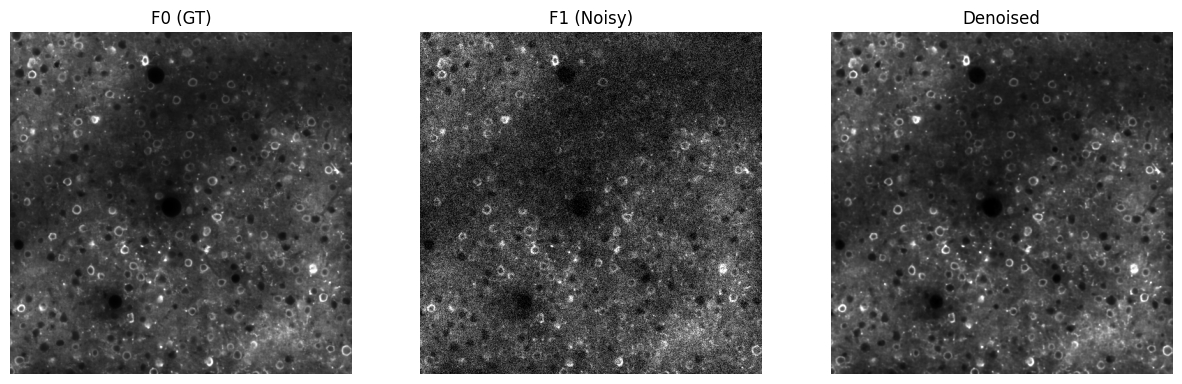

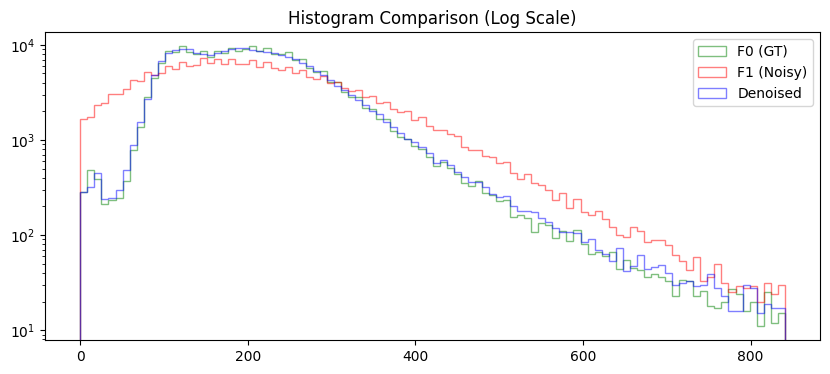

--- Inspecting frame index: 1499 ---
[F0 (GT)] Min: 1.0000, Max: 2393.0000, Mean: 211.3260, Median: 201.0000
[F1 (Noisy)] Min: -208.0000, Max: 2826.0000, Mean: 211.0904, Median: 192.0000
[Denoised] Min: -3.7364, Max: 1907.9895, Mean: 211.5050, Median: 200.2088


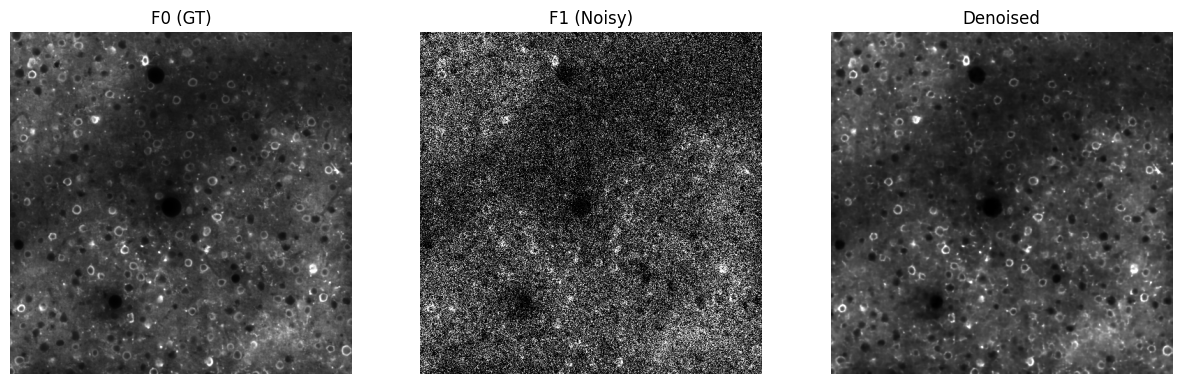

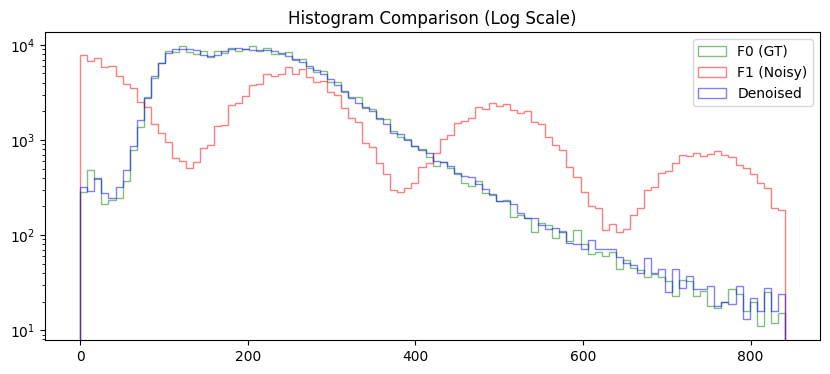

--- Inspecting frame index: 1499 ---
[F0 (GT)] Min: 1.0000, Max: 2393.0000, Mean: 211.3260, Median: 201.0000
[F1 (Noisy)] Min: -213.0000, Max: 5053.0000, Mean: 210.5263, Median: 15.0000
[Denoised] Min: -10.8406, Max: 1465.1161, Mean: 207.9759, Median: 196.4094


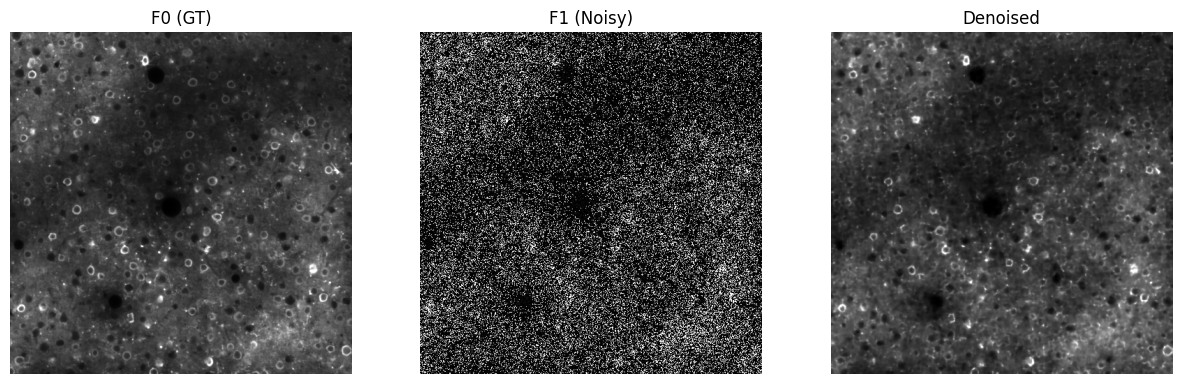

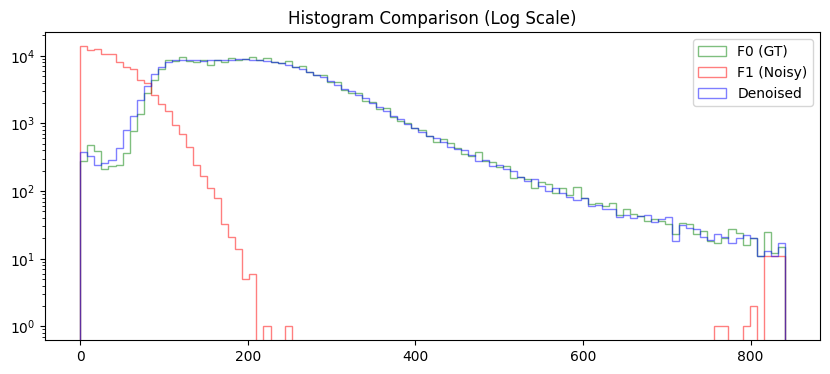

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def inspect_brightness(f0, f1, denoised, img_idx=0):
    """
    輸入三個影像 (假設都是 Numpy Array)
    """

    print(f"--- Inspecting frame index: {img_idx} ---")

    imgs = [f0[img_idx], f1[img_idx], denoised[img_idx]]
    names = ['F0 (GT)', 'F1 (Noisy)', 'Denoised']

    plt.figure(figsize=(15, 5))

    vmin, vmax = np.percentile(f0, (0, 99.9))

    for i, (img, name) in enumerate(zip(imgs, names)):
        # 1. 印出統計數值 (最準確)
        print(f"[{name}] Min: {img.min():.4f}, Max: {img.max():.4f}, Mean: {img.mean():.4f}, Median: {np.median(img):.4f}")

        # 2. 畫圖 (用同樣的 vmin/vmax 比較才公平)
        # 我們統一用 F0 的標準來看
    
        plt.subplot(1, 3, i+1)
        plt.title(name)
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        plt.axis('off')

    plt.show()

    # 3. 畫直方圖 (檢查背景有沒有偏移)
    plt.figure(figsize=(10, 4))
    plt.title("Histogram Comparison (Log Scale)")
    for img, name, color in zip(imgs, names, ['green', 'red', 'blue']):
        # flatten 拉平，bins 設多一點
        plt.hist(img.flatten(), bins=100, range=(vmin, vmax),
                 alpha=0.5, label=name, color=color, log=True, histtype='step')
    plt.legend()
    plt.show()

img_idx = (ground_truth.shape[0]) - 1
inspect_brightness(ground_truth, valid_dataset.images[0], denoised_videos[0], img_idx=img_idx)
inspect_brightness(ground_truth, valid_dataset.images[1], denoised_videos[1], img_idx=img_idx)
inspect_brightness(ground_truth, valid_dataset.images[2], denoised_videos[2], img_idx=img_idx)

In [ ]:
from matplotlib import axes
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interact_viewer(gt, noised, denoised):
    vmin, vmax = np.percentile(gt, (2, 70))
    # vmin, vmax = gt.min(), gt.max()
    print(vmin, vmax)

    def view_frame(t):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(gt[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[0, 0].set_title(f"Gound Truth (t={t})")
        axs[0, 0].axis('off')

        axs[0, 1].axis('off')

        axs[1, 0].imshow(noised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 0].set_title(f"Noised (t={t})")
        axs[1, 0].axis('off')

        axs[1, 1].imshow(denoised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 1].set_title(f"Denoised (t={t})")
        axs[1, 1].axis('off')

        plt.show()

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(gt)-1,
        step=1,
        description='Time Frame:'
    )

    widgets.interact(view_frame, t=slider)

# interact_viewer(ground_truth, valid_dataset.images[0], denoised_videos[0])
# interact_viewer(valid_dataset.images[0], valid_dataset.images[1])